# Статистика, DS-поток
## Практическое задание 11


**Правила:**

* Дедлайн **23 ноября 16:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot`.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 &mdash; 10 баллов;
* Задача 2 &mdash; 10 баллов;
* Задача 3 &mdash; 10 баллов.

**Важность задач:**

* *высокая:* задачи 1, 2;
* *средняя:* задача 3.

In [ ]:
import numpy as np
from numpy import linalg as la

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.graph_objects as go
import plotly.express as px

from IPython.display import display

import scipy.stats as sps
import scipy.linalg as sla
import statsmodels.formula.api as smf
from sklearn.preprocessing import OneHotEncoder

from statsmodels.stats.multitest import multipletests

sns.set(font_scale=1.3, style='whitegrid', palette='Set2')

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from tqdm import gui
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
%ls
%cd 'gdrive/MyDrive/DS/task11'

gdrive/  sample_data/
/content/gdrive/MyDrive/DS/task11


In [117]:
%%shell
jupyter nbconvert --to html 'task11.ipynb'

[NbConvertApp] Converting notebook task11.ipynb to html
[NbConvertApp] Writing 1885959 bytes to task11.html


__________________
## Задача 1.

По шаблону напишите класс, реализующий линейную регрессию. Интерфейс этого класса в некоторой степени соответствует классу <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression">`LinearRegression`</a> из библиотеки `sklearn`.

**Примечание**: беру доверительный и предсказательный интервалы на для отклика из 3 задачи Теор. Дз 11 без док-ва

In [ ]:
class MyLinearRegression:
    '''
    Класс, реализующий линейную регрессию c помощью МНК.
    '''
    
    def __init__(self, fit_intercept=True, alpha=0.05):
        '''   
        :param fit_intercept: добавлять ли смещение(константный признак)
        :param alpha: уровень значимости критерия, 
                      (1-alpha): уровень доверия дов. интервала
        '''
        self.fit_intercept = fit_intercept
        self.alpha = alpha
        
    def fit(self, X, Y, fit_intercept=True, names=None):
        '''
        Функция обучения модели. 
        
        Предполагается модель Y = X * theta + epsilon, 
        где epsilon имеет норм. распр. с параметрами (0, sigma^2 * I_n).
        
        :param X: регрессор (матрица размера n x d), 
        :param Y: отклик (матрица размера n x 1),
        :param fit_intercept: добавлять ли смещение(константный признак),
        :param names: имена столбцов данных

        '''

        self.names = names

        self.fit_intercept = fit_intercept

        X_ = np.array(X)
        if len(X_.shape) == 1:
            X_ = X_[:, np.newaxis]
        
        # При необходимости добавьте константу, используйте self.fit_intercept
        if self.fit_intercept:
            X_ = np.hstack([X_, np.ones(shape=(X_.shape[0], 1))])

        Y_ = np.array(Y)
        self.n, self.d = X_.shape
        self.t_quantile = sps.t.isf((self.alpha / 2), df=(self.n - self.d))
        
        self.XTX_inv = la.inv(X_.T.dot(X_))  # (X^TX)^-1

        # оценка theta
        self.theta = self.XTX_inv @ X_.T @ Y_

        # несмещенная оценка для sigma^2
        self.sigma_sq = la.norm(Y_ - X_ @ self.theta)**2 / (self.n - self.d)
        self.sigma = np.sqrt(self.sigma_sq)

        # доверительные интервалы для коэффициентов (матрица размера d x 2)
        XTX_inv_diag_sqrt = np.sqrt(np.diag(self.XTX_inv))

        self.conf_int = self.theta[:, np.newaxis] + self.t_quantile * self.sigma * np.array([[-1, 1]]) * XTX_inv_diag_sqrt[:, np.newaxis]

        # статистики критериев о незначимости коэффициентов (вектор размера d)
        self.t_stats = self.theta / (self.sigma * XTX_inv_diag_sqrt)

        # p-value критериев о незначимости коэффициентов (вектор размера d)
        self.pvalue = 2 * sps.t(df=(self.n - self.d)).sf(np.abs(self.t_stats))
        
        return self
    
    def summary(self, suppress_output=False):
        '''
        Печатает таблицу с информацией для каждого коэффициента,
        в которой указана его оценка, границы дов. интервала,
        статистика критерия и значение p-value
        :param suppress_output: не выводить информацию о sigma,
        когда идет обработка для многих случае обучения

        '''
        
        if not suppress_output:
            print(f'Линейная регрессия на {self.d} признаках и {self.n} объектах')
            print(f'Sigma: {self.sigma_sq:.6f}')
        
        # Далее напечатайте таблицу, 
        # в которой для каждого коэффициента (по строкам)
        # будут следующие столбцы:
        # оценка, границы дов. интервала (два столбца), 
        # статистика критерия, p-value

        test = multipletests(self.pvalue, method='holm', alpha=self.alpha)
        data = np.hstack([
            self.theta[:, np.newaxis],
            self.conf_int,
            self.t_stats[:, np.newaxis],
            self.pvalue[:, np.newaxis],
            test[1][:, np.newaxis]
        ])
        columns = [
            "Оценка коэффициента",
            "[0.025   ",
            "0.975]",
            "T_0(X, Y)",
            "p-value",
            "corrected p-value"
        ]
        
        index = self.names
        if len(index) < self.d:
            while len(index) < self.d:
                index.append(len(index))
            if self.fit_intercept:
                index[-1] = "Intercept"

        return pd.DataFrame(data=data, columns=columns, index=index)
        
    def predict(self, X, type_interval=None):
        '''
        Возвращает предсказание отклика на новых объектах X 
        и опционально доверительный/предсказательный интервал.
        
        :param X: матрица объектов размера n x d
        :param type_interval: тип дов. интервала. 
                        Для этого параметра возможны три варианта:
                        * None - возвратить только предсказание, 
                                размер return-a: n;
                        * 'confidence' - возвратить предсказание и 
                            доверительный интервал для среднего отклика, 
                            размер return-a: n x 3;
                        * 'prediction' - возвратить предсказание и 
                            предсказательный интервал для новых объектов, 
                            размер return-a: n x 3.
                              
        :return y_pred: предсказание/предсказание и дов./предсказ. инт.
                        
        '''

        X_ = np.array(X)
        if len(X_.shape) == 1:
            X_ = X_[:, np.newaxis]
        
        # При необходимости добавьте константу, используйте self.fit_intercept
        if self.fit_intercept:
            X_ = np.hstack([X_, np.ones(shape=(X_.shape[0], 1))])
        
        y_pred = X_ @ self.theta

        if type_interval is not None:
            if type_interval == 'confidence':
                y_confidence = y_pred + self.t_quantile * self.sigma * np.array([[-1, 1]]) * np.sqrt(np.diag(X_ @ self.XTX_inv @ X_.T))
                y_pred = np.hstack([y_pred[:, np.newaxis], y_confidence])
            elif type_interval == 'prediction':
                y_prediction = y_pred + self.t_quantile * self.sigma * np.array([[-1, 1]]) * np.sqrt(1 + np.diag(X_ @ self.XTX_inv @ X_.T))
                y_pred = np.hstack([y_pred[:, np.newaxis], y_prediction])
            else:
                raise ValueError('Unexpected type of interval')

        return y_pred

Загрузите данные о потреблении мороженного в зависимости от температуры воздуха и цены (файл `ice_cream.txt`).
Примените реализованный выше класс линейной регрессии к этим данным предполагая, что модель имеет вид $ic = \theta_1 + \theta_2\ t$, где $t$ — температура воздуха (столбец `temp`), $ic$ — потребление мороженного в литрах на человека (столбец `IC`).
Значения температуры предварительно переведите из Фаренгейта в Цельсий. Преобразование температуры по шкале Фаренгейта в температуру по шкале Цельсия: $t_C = \frac{(t_F - 32)}{1,8}$ 

К обученной модели примените фунцию `summary` и постройте график регрессии, то есть график прямой $ic = \widehat{\theta}_1 + \widehat{\theta}_2\ t$, где $\widehat{\theta}_1, \widehat{\theta}_2$ — МНК-оценки коэффициентов.
На график нанесите точки выборки. Постройте также доверительный интервал для среднего отклика и предсказательный интервал. В чем их различие? Проанализируйте результаты.

In [ ]:
ice_cream = pd.read_csv('ice_cream.txt', sep="\t", header=0)
ice_cream.rename(columns={'temp': 'temp_F'}, inplace=True)

# data['temp_C'] = np.round((data['temp_F'] - 32) / 1.8)
ice_cream['temp_C'] = (ice_cream['temp_F'] - 32) / 1.8

encoder = OneHotEncoder(categories=np.unique(ice_cream.Year).reshape(1, -1))

ice_cream.loc[:, ['year_0', 'year_1', 'year_2']] = encoder.fit_transform(ice_cream['Year'].to_numpy().reshape(-1, 1)).toarray()

ice_cream.head(7)

,date,IC,price,income,temp_F,Lag-temp,Year,temp_C,year_0,year_1,year_2
0,1,0.386,0.270,78,41,56,0,5.000000,1.0,0.0,0.0
1,2,0.374,0.282,79,56,63,0,13.333333,1.0,0.0,0.0
2,3,0.393,0.277,81,63,68,0,17.222222,1.0,0.0,0.0
3,4,0.425,0.280,80,68,69,0,20.000000,1.0,0.0,0.0
4,5,0.406,0.272,76,69,65,0,20.555556,1.0,0.0,0.0
5,6,0.344,0.262,78,65,61,0,18.333333,1.0,0.0,0.0
6,7,0.327,0.275,82,61,47,0,16.111111,1.0,0.0,0.0


Сравним для своего спокойствия с библиотечной реализацией

In [ ]:
model = smf.ols(formula="IC ~ temp_C", data=ice_cream)
res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     IC   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     42.28
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           4.79e-07
Time:                        06:46:25   Log-Likelihood:                 53.383
No. Observations:                  30   AIC:                            -102.8
Df Residuals:                      28   BIC:                            -99.96
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3063      0.011     27.253      0.0

In [ ]:
def check_my_model(features):
    my_model = MyLinearRegression()
    my_res = my_model.fit(ice_cream.loc[:, features], ice_cream.IC, names=features)

    return my_res.summary()

check_my_model(['temp_C']).style.format('{:.4f}')

Линейная регрессия на 2 признаках и 30 объектах
Sigma: 0.001786


,Оценка коэффициента,[0.025,0.975],"T_0(X, Y)",p-value,corrected p-value
temp_C,0.0056,0.0038,0.0074,6.5023,0.0000,0.0000
Intercept,0.3063,0.2833,0.3293,27.2532,0.0000,0.0000


Теперь учтите влияние года (столбец `Year`) для двух случаев.
* Модель $ic = \theta_1 + \theta_2\ t + \theta_3 y_1 + \theta_4 y_2$, где $y_1 = I\{1\ год\}, y_2 = I\{2\ год\}$. Поясните, почему нельзя рассмативать одну переменную $y$ — номер года.
* Для каждого года рассматривается своя линейная зависимость $ic = \theta_1 + \theta_2\ t$.

В каждом случае нарисуйте графики. Отличаются ли полученные результаты? Почему? От чего это зависит? Как зависит потребление мороженного от года? 

Во-первых, влияние года вряд ли монотонное, т.е. с его увеличением не обязательно всегда увеличивается или уменьшается целевой показатель. Кроме того, возможных годов здесь немного, поэтому кодирование этого признака таким образом точно не ухудшить работу регрессии

Первый случай

In [ ]:
features = ['temp_C', 'year_1', 'year_2']

my_model = MyLinearRegression()
my_res = my_model.fit(ice_cream.loc[:, features], ice_cream.IC, names=features)

summary = my_res.summary()
summary.style.format('{:.4f}')

Линейная регрессия на 4 признаках и 30 объектах
Sigma: 0.001016


,Оценка коэффициента,[0.025,0.975],"T_0(X, Y)",p-value,corrected p-value
temp_C,0.0061,0.0047,0.0074,9.2513,0.0000,0.0000
year_1,0.0165,-0.0112,0.0442,1.2225,0.2325,0.2325
year_2,0.0743,0.0415,0.1071,4.6607,0.0001,0.0002
Intercept,0.2770,0.2512,0.3029,22.0103,0.0000,0.0000


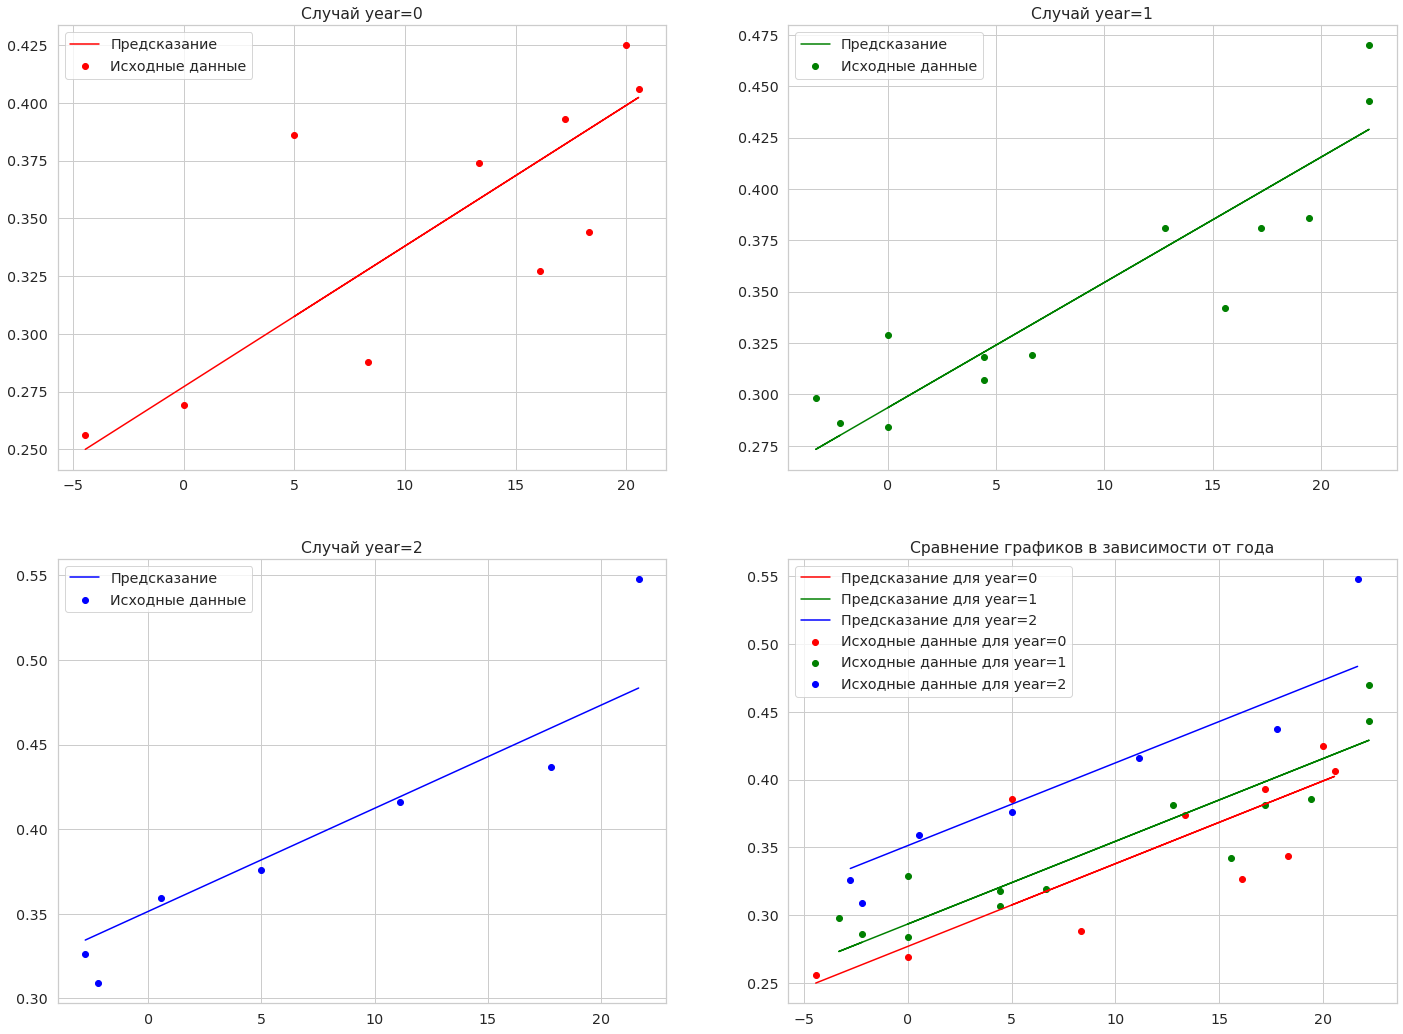

In [ ]:
features = ['temp_C', 'year_1', 'year_2']
prediction = my_model.predict(ice_cream.loc[:, features])

fig, axs = plt.subplots(2, 2, figsize=(24, 18))
axs = axs.flatten()

for label, color, ax in zip(['year_0', 'year_1', 'year_2'], ['r', 'g', 'b'], axs):
    idx = ice_cream[label] == 1
    ax.scatter(ice_cream[idx].temp_C, ice_cream[idx].IC, color=color, label='Исходные данные')
    ax.plot(ice_cream[idx].temp_C, prediction[idx], color=color, label='Предсказание')
    ax.set_title('Случай ' + label.replace('_', '='))
    ax.legend(loc='upper left')

ax = axs[-1]
for label, color in zip(['year_0', 'year_1', 'year_2'], ['r', 'g', 'b']):
    idx = ice_cream[label] == 1
    ax.plot(ice_cream[idx].temp_C, prediction[idx], color=color, label='Предсказание для ' + label.replace('_', '='))
    ax.scatter(ice_cream[idx].temp_C, ice_cream[idx].IC, color=color, label='Исходные данные для ' + label.replace('_', '='))
ax.set_title('Сравнение графиков в зависимости от года')
ax.legend(loc='upper left')

fig.show()

Второй случай

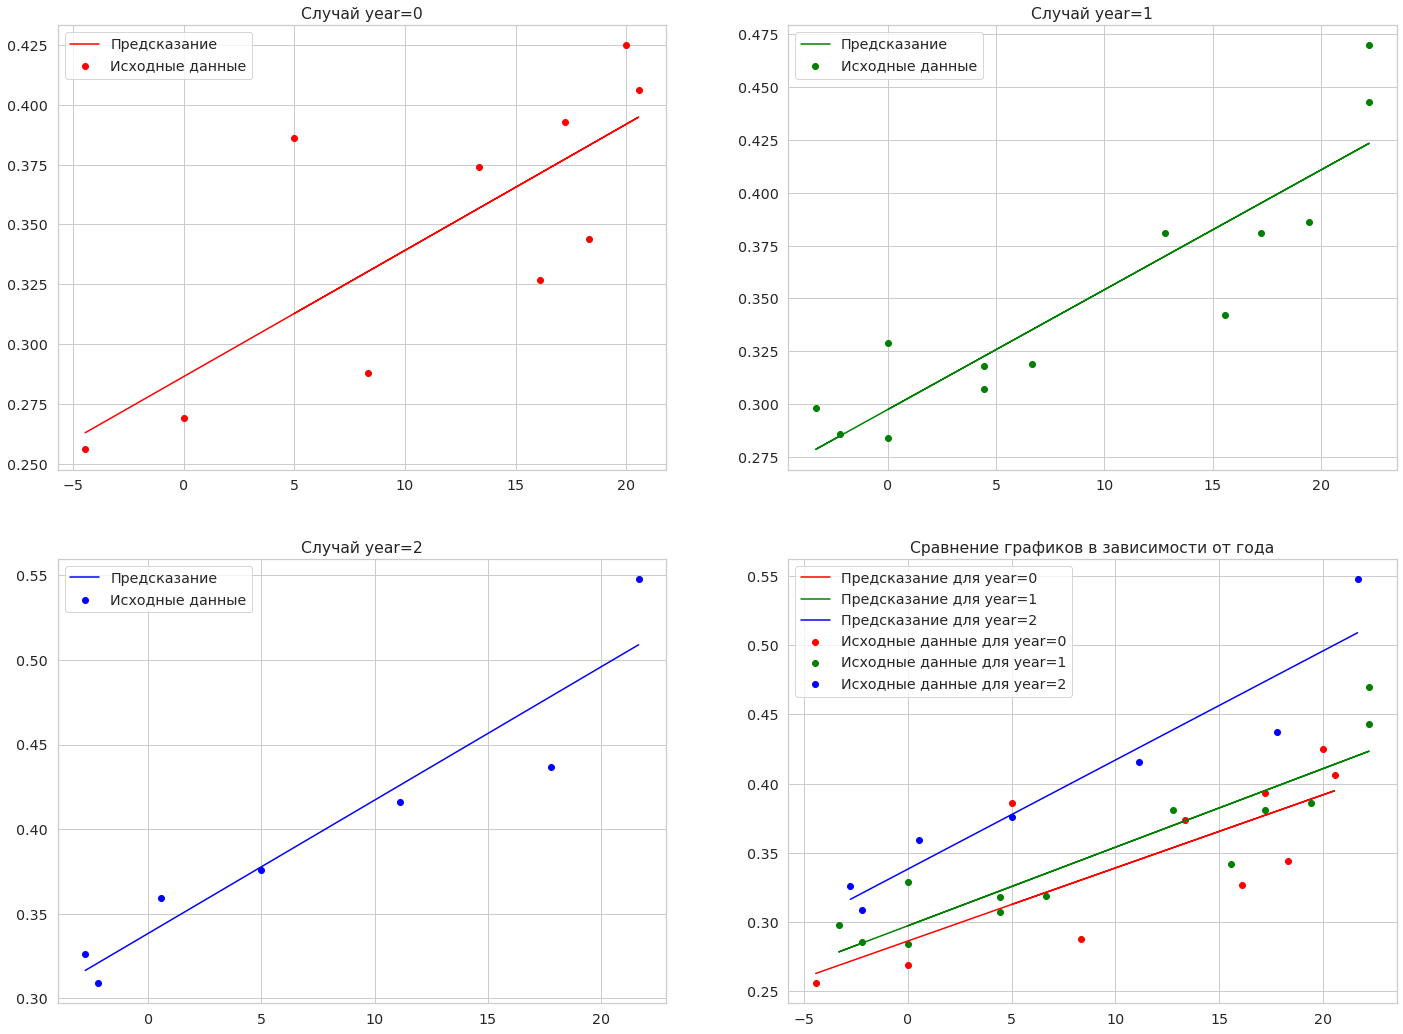

In [ ]:
predictions = []
models = []

years = ['year_0', 'year_1', 'year_2']

for label in years:
    idx = ice_cream[label] == 1
    model = MyLinearRegression().fit(ice_cream.loc[idx].temp_C, ice_cream[idx].IC, names=['temp_C'])
    predictions.append(model.predict(ice_cream.loc[idx].temp_C))
    models.append(model)

fig, axs = plt.subplots(2, 2, figsize=(24, 18))
axs = axs.flatten()

for label, color, ax, prediction in zip(years, ['r', 'g', 'b'], axs, predictions):
    idx = ice_cream[label] == 1
    ax.scatter(ice_cream[idx].temp_C, ice_cream[idx].IC, color=color, label='Исходные данные')
    ax.plot(ice_cream[idx].temp_C, prediction, color=color, label='Предсказание')
    ax.set_title('Случай ' + label.replace('_', '='))
    ax.legend(loc='upper left')

ax = axs[-1]
for label, color, prediction in zip(years, ['r', 'g', 'b'], predictions):
    idx = ice_cream[label] == 1
    ax.plot(ice_cream[idx].temp_C, prediction, color=color, label='Предсказание для ' + label.replace('_', '='))
    ax.scatter(ice_cream[idx].temp_C, ice_cream[idx].IC, color=color, label='Исходные данные для ' + label.replace('_', '='))
ax.set_title('Сравнение графиков в зависимости от года')
ax.legend(loc='upper left')

fig.show()

In [ ]:
models[0].summary().style.format('{:.4f}')

Линейная регрессия на 2 признаках и 10 объектах
Sigma: 0.001597


,Оценка коэффициента,[0.025,0.975],"T_0(X, Y)",p-value,corrected p-value
temp_C,0.0053,0.0018,0.0088,3.4868,0.0082,0.0082
Intercept,0.2864,0.2370,0.3358,13.3582,0.0000,0.0000


In [ ]:
models[1].summary().style.format('{:.4f}')

Линейная регрессия на 2 признаках и 13 объектах
Sigma: 0.000667


,Оценка коэффициента,[0.025,0.975],"T_0(X, Y)",p-value,corrected p-value
temp_C,0.0057,0.0039,0.0074,7.1857,0.0000,0.0000
Intercept,0.2974,0.2750,0.3199,29.1817,0.0000,0.0000


In [ ]:
models[2].summary().style.format('{:.4f}')

Линейная регрессия на 2 признаках и 7 объектах
Sigma: 0.000766


,Оценка коэффициента,[0.025,0.975],"T_0(X, Y)",p-value,corrected p-value
temp_C,0.0079,0.0049,0.0108,6.8178,0.0010,0.0010
Intercept,0.3383,0.3038,0.3729,25.1802,0.0000,0.0000


Результат:

1. Потребление мороженого в последний представленный год выше всего
2. Как и ожидалось, в силу того, что для каждого года обучается своя линейная регрессия, графики будут иметь разный наклон, когда в первом случае минимизируется ошибка для всех случаев сразу и лишь признак с годом позволяет графику быть выше или ниже
3. Summary во всех трех случаях похожи (т.е., коэффициенты и дов. интервалы), однако польностью все-таки не совпадают: в разных случаях признаки влияли немного по разному

Наконец, обучите модель на предсказание потребления мороженного в зависимости от всех признаков, кроме `Lag-Temp`.
Не забудьте, что для года нужно ввести две переменных.
Для полученной модели выведите `summary`.

In [ ]:
features = ['price', 'income', 'temp_C', 'year_1', 'year_2']

my_model = MyLinearRegression()
my_res = my_model.fit(ice_cream.loc[:, features], ice_cream.IC, names=features)

summary = my_res.summary()
summary.style.format('{:.4f}')

Линейная регрессия на 6 признаках и 30 объектах
Sigma: 0.000981


,Оценка коэффициента,[0.025,0.975],"T_0(X, Y)",p-value,corrected p-value
price,-0.6713,-2.3862,1.0436,-0.8079,0.4271,0.4271
income,-0.0032,-0.0077,0.0012,-1.5048,0.1454,0.2909
temp_C,0.0056,0.0042,0.0071,7.9747,0.0000,0.0000
year_1,0.0382,0.0003,0.0762,2.0819,0.0482,0.1446
year_2,0.1179,0.0472,0.1886,3.4405,0.0021,0.0107
Intercept,0.7204,0.1315,1.3092,2.5248,0.0186,0.0744


Но это еще не все.
Постройте теперь линейную регрессию для модели $ic = \theta_1 + \theta_2\ t + \theta_3\ t^2 + \theta_4\ t^3$.
Выведите для нее summary и постройте график предсказания, то есть график кривой $ic = \widehat{\theta}_1 + \widehat{\theta}_2\ t + \widehat{\theta}_3\ t^2 + \widehat{\theta}_4\ t^3$. Хорошие ли получаются результаты?

In [ ]:
ice_cream['temp_C^2'] = ice_cream['temp_C']**2
ice_cream['temp_C^3'] = ice_cream['temp_C']**3

features = ['temp_C', 'temp_C^2', 'temp_C^3']

my_model = MyLinearRegression()
my_res = my_model.fit(ice_cream.loc[:, features], ice_cream.IC, names=features)

summary = my_res.summary()
summary.style.format('{:.4f}')

Линейная регрессия на 4 признаках и 30 объектах
Sigma: 0.001529


,Оценка коэффициента,[0.025,0.975],"T_0(X, Y)",p-value,corrected p-value
temp_C,0.0072,0.0004,0.0140,2.1725,0.0391,0.1155
temp_C^2,-0.0009,-0.0019,0.0002,-1.7457,0.0927,0.1155
temp_C^3,0.0000,0.0000,0.0001,2.1801,0.0385,0.1155
Intercept,0.3199,0.2953,0.3445,26.7220,0.0000,0.0000


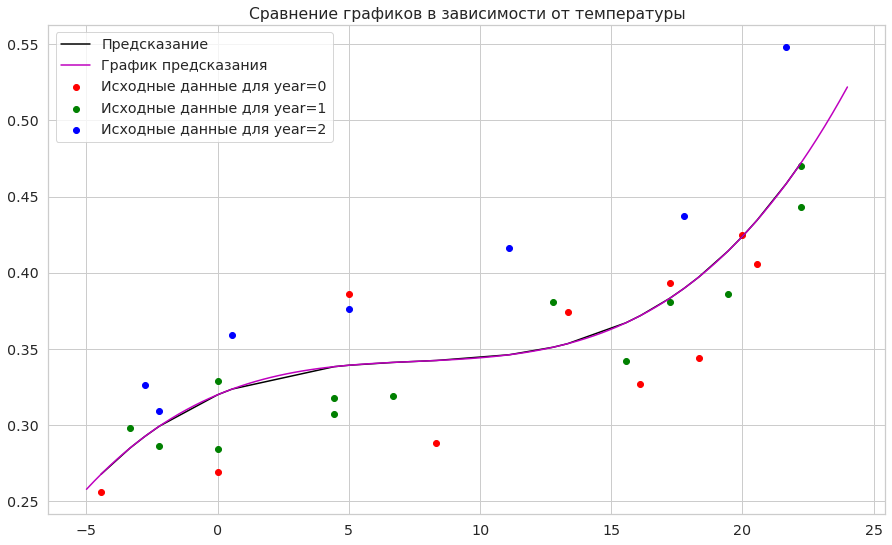

In [ ]:
features = ['temp_C', 'temp_C^2', 'temp_C^3', 'year_0', 'year_1', 'year_2']
data = ice_cream.loc[:, features]

prediction = my_model.predict(ice_cream.loc[:, features[:3]])

data['prediction'] = prediction
data.sort_values(by=['temp_C'], inplace=True)

plt.figure(figsize=(15, 9))

for label, color in zip(years, ['r', 'g', 'b']):
    idx = ice_cream[label] == 1
    plt.scatter(ice_cream[idx].temp_C, ice_cream[idx].IC, color=color, label='Исходные данные для ' + label.replace('_', '='))

plt.plot(data.temp_C, data.prediction, color='k', label='Предсказание')

ts = np.linspace(-5, 24, 100)
t_prediction = my_model.predict(np.vstack([ts, ts**2, ts**3]).T)

plt.plot(ts, t_prediction, color='m', label='График предсказания')

plt.title('Сравнение графиков в зависимости от температуры')
plt.legend(loc='upper left')

plt.show()

(почти совпали графики для большого количества точек на отрезке $[-5, 24]$ и для всех точек из исходных даных)

Предсказание получается не очень информативным: мы уже и так знали, что с увеличением температуры потребление мороженого увлечивается

Возможно, в этом случае ожидался "пляшущий" график зависимости предсказания от температуры, однако этого не случилось

Чтобы понять, почему так происходит, выведите значения матрицы $(X^T X)^{-1}$ для данной матрицы и посчитайте для нее индекс обусловленности $\sqrt{\left.\lambda_{max}\right/\lambda_{min}}$, где $\lambda_{max}, \lambda_{min}$ — максимальный и минимальный собственные значения матрицы $X^T X$. Собственные значения можно посчитать функцией <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eigvals.html">`scipy.linalg.eigvals`</a>.

Прокомментируйте полученные результаты. Помочь в этом может следующая <a href="https://ru.wikipedia.org/wiki/%D0%A7%D0%B8%D1%81%D0%BB%D0%BE_%D0%BE%D0%B1%D1%83%D1%81%D0%BB%D0%BE%D0%B2%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8">статья</a>.

In [ ]:
eigvals = np.abs(sla.eigvals(my_model.XTX_inv))

np.sqrt(eigvals.max() / eigvals.min())

8140.394748958992

Получили здоровенное число обусловленности. С лекции знаем, что это признак мультиколлинеарности. Однако, коэффициенты не были слишком большими. С другой стороны, из значимых критерии о незначимости коэффициентов не отвергаются, что тоже может указывать на мультиколлинеарность

**Вывод:**

В результате, при использовании всех данных температура и информация о годе (а точнее, индикатор второго года) оказались самым важным показателем: критерий о незначимости температуры был отвергнут в большинстве случаев. В зависимости от года проглядывается изменение потребления мороженого в сторону увеличения, хоть и критерий о незначимости этого коэффициента и не был отвергнут так часто

Число обусловленности говорит о зависимости между различными степенями температуры, что может говорить о том, что нет смысла использовать температуру в степени выше 1, т.к. данные располагаются достаточно "линейно", что скорее всего было бы видно лучше при большем количестве данных

______________
## Задача 2.

В данной задаче нужно реализовать функцию отбора признаков для линейной регрессии. Более подробно, пусть у объектов есть признаки $x_1, ... , x_k$. Нужно определить, какое подмножество признаков $x_{j_1}, ... , x_{j_s}$ нужно использовать, чтобы качество полученной модели $y = \theta_0 + \theta_{j_1} x_{j_1} + ... + \theta_{j_s} x_{j_s}$ было максимальным.

Один из методов, решающих эту задачу описан далее.

Сначала имеющаяся выборка случайно разделяется на обучающую выборку, валидационную и тестовую (train, validation и test). Для некоторого подмножества признаков на обучающей выборке обучается модель, после чего вычисляется её качество на валидационной выборке. Операция повторяется для всех подмножеств признаков. Лучшей считается модель с наилучшим качеством на валидационной выборке.

Иначе говоря, сначала выборка $X$ разделяется по объектам на $X_{train} \sqcup X_{validation} \sqcup X_{test} = X$ . Далее, в цикле по всем подмножествам индексов признаков $(j_1, \dots, j_s)$ на обучающей выборке $X_{train}$ обучается модель $y = \theta_{j_1} x_{j_1} + ... + \theta_{j_s} x_{j_s}$, после чего считается её качество на $X_{validation}$. В конечном итоге для оптимального подмножества признаков считается качество на тестовой выборке.

В данной задаче предлагается рассмотреть несколько метрик качества.

Пусть $X_{set}$ &mdash; некоторое множество объектов.

* Средний квадрат ошибки (mean squared error)

$$MSE = \frac{1}{n} \sum\limits_{x \in X_{set}} \left(\widehat{y}(x) - Y(x)\right)^2.$$
   
* Средний модуль отклонения (mean absolute error)
$$MAE = \frac{1}{n} \sum\limits_{x \in X_{set}} \left|\widehat{y}(x) - Y(x)\right|.$$

* Средняя абсолютная ошибка (mean absolute percentage error)
$$MAPE = \frac{100 \%}{n} \sum\limits_{x \in X_{set}} \left|\frac{\widehat{y}(x) - Y(x)}{Y(x)}\right|.$$

Здесь $x$ — объект, $Y(x)$ — значение целевой переменной (отклика) на объекте $x$, а $\widehat{y}(x)$ — оценка отклика на объекте $x$.

Заметим, что полный перебор подмножеств признаков требует большого времени. Проблема отбора признаков состоит в том, что могут быть два признака, добавление каждого из которых ухудшает (не улучшает) качество, но добавление двух признаков сразу увеличивает качество.

Для выполнения задания воспользуйтесь следующими функциями:
* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression">`sklearn.linear_model.LinearRegression`</a> — реализация линейной регрессии. В данной реализации свободный параметр $\theta_1$ по умолчанию автоматически включается в модель. Отключить это можно с помощью `fit_intercept=False`, но это не нужно. *В данной задаче требуется, чтобы вы воспользовались готовой реализацией линейной регрессии, а не своей. Ведь на практике важно уметь применять готовые реализации, а не писать их самостоятельно.*

* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">`sklearn.model_selection.train_test_split`</a> — функция разбиения данных на train и test. Разбейте данные на train / validation / test в пропорции 3:1:1. Установите параметр `random_state=17`.

* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html">`sklearn.metrics.mean_squared_error`</a> — реализация MSE.

* <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html">`sklearn.metrics.mean_absolute_error`</a> — реализация MAE.

* <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html#sklearn.metrics.mean_absolute_percentage_error">`sklearn.metrics.mean_absolute_percentage_error`</a> — реализация MAPE.

Для перебора реализуйте следующий класс. Данный класс частично реализует интерфейс, похожий на интерфейс <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">`sklearn.model_selection.GridSearchCV`</a>

###### BestFeaturesSelection

In [ ]:
class BestFeaturesSelection:
    '''
    Класс, реализующий отбор наилучших признаков.
    '''
    
    def __init__(self, estimator, scoring, parameters=dict(), 
                 val_size=0.25, random_state=17, minimize=True):
        '''
        :param estimator: конструктор класса, например, LinearRegression
        :param scoring: функция риска, например, mean_squared_error
        :param paramters: параметры, передаваемые конструктору estimator, 
                          например dict(fit_intercept=False)
        :param val_size: доля валидационной выборки
        :param random_state: random state
        :param minimize: минимизировать ли функционал качества, 
                         если True - минимизровать, иначе - максимизировать
        '''
        
        self.estimator = estimator
        self.parameters = parameters
        self.scoring = scoring
        self.val_size = val_size
        self.random_state = random_state
        self.minimize=minimize
        
    def fit(self, X, y):
        '''
        Подбор лучшего подмножества признаков и обучение модели на нём.
        
        :param X: регрессор (матрица размера n x d)
        :param y: отклик (матрица n x 1)
        
        :return best_estimator: объект класса self.estimator, обученный
                                на наилучшем подмножестве признаков по
                                функции риска self.scoring
        '''

        X_ = np.array(X)
        if len(X_.shape) == 1:
            X_ = X_[:, np.newaxis]
        y_ = np.array(y)

        # разделение выборки на train и validation. Не перепутайте порядок!
        X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=self.val_size, random_state=self.random_state)
        # список пар (вектор использованных признаков, знач. функции потерь)
        self.results_ = []
        features_count = X_.shape[1]
        # перебор по всем подмножествам признаков
        for bitmask in range(1, 2 ** features_count):
            # получим рассматриваемое подмножество признаков
            subset = [i == "1" for i in \
                      np.binary_repr(bitmask, width=features_count)]
            # вычисление качества модели
            estimator = self.estimator(**self.parameters)
            estimator.fit(X_train[:, subset], y_train)
            score = self.scoring(estimator.predict(X_val[:, subset]), y_val)
    
            self.results_.append((subset, score))
        
        # сортируем по второму элементу в нужном порядке
        self.results_.sort(key = lambda pair: pair[1], 
                           reverse=not self.minimize) 
        # сохраним лучшее подмножество признаков
        self._best_subset = self.results_[0][0]
        # создадим объект класса self.estimator 
        self._best_estimator = self.estimator(**self.parameters)
        # обучимся на лучшем подмножестве признаков
        self._best_estimator.fit(X_[:, self._best_subset], y)
        
        return self._best_estimator
        
    def predict(self, X):
        '''
        Предсказание модели, обученной на наилучшем подмножестве признаков.
        
        :param X: объекты (матрица размера n x d)
        :return pred: предсказание модели для наилучшего подмножества признаков
        '''
        X_ = np.array(X)
        if len(X_.shape) == 1:
            X_ = X_[:, np.newaxis]

        pred = self._best_estimator.predict(X_[:, self._best_subset])
        return pred

Примените реализованный отбор признаков и посчитайте итоговое качество на тестовой выборке для двух датасетов
* <a href="http://archive.ics.uci.edu/ml/datasets/Yacht+Hydrodynamics">Yacht Hydrodynamics</a> — для парусных яхт нужно оценить остаточное сопротивление на единицу массы смещения (последний столбец) в зависимости от различных характеристик яхты.

* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston">Boston Housing Prices</a> — цены на дома в Бостоне в зависимости от ряда особенностей.

Посмотрите на **графики** зависимости целевой переменной от каждого признака. Какие бы признаки вы стали использовать? Совпадает ли ваш выбор с результатом процедуры, описанного выше? 

Обратите внимание, что сначала рекомендуется выделить из исходной выборки тестовую часть. Тестовая выборка нужна, чтобы оценить качество конечной модели и сообщить его заказчику, больше тестовые данные никак не задействуются. Для обучения и подбора оптимального множества признаков используйте оставшуюся часть выборки. Имейте в виду, что разбиение на validation / train происходит внутри метода `fit` класса `BestFeaturesSelection`.

##### **Yacht Hydrodynamics**

Для парусных яхт нужно оценить остаточное сопротивление на единицу массы смещения (последний столбец) в зависимости от различных характеристик яхты.

 \+ графики зависимости целевой переменной от каждого признака

In [ ]:
columns = [
    'Longitudinal Position', 'Prismatic Coefficient',
    'Length-Displacement', 'Beam-Draught Ratio',
    'Length-Beam Ratio', 'Froude Number',
    'Residuary Resistance'
]

yacht = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data',
                    header=None, delimiter='\s+', names=columns)

yacht.sample(7)

,Longitudinal Position,Prismatic Coefficient,Length-Displacement,Beam-Draught Ratio,Length-Beam Ratio,Froude Number,Residuary Resistance
67,-2.4,0.574,4.36,3.96,2.76,0.400,21.51
288,-2.3,0.600,5.10,4.17,3.51,0.325,6.31
49,-2.3,0.564,5.10,3.95,3.53,0.300,3.99
53,-2.3,0.564,5.10,3.95,3.53,0.400,21.51
210,-2.3,0.530,4.34,2.81,3.15,0.125,0.05
91,-2.3,0.562,5.14,4.95,3.17,0.300,4.09
71,-2.4,0.568,4.34,2.98,3.15,0.150,0.26


In [ ]:
random_state = 17

In [ ]:
X = yacht.loc[:, columns[:-1]]
y = yacht.loc[:, ['Residuary Resistance']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state)

scorings = {"MSE": mean_squared_error, "MAE": mean_absolute_error, "MAPE": mean_absolute_percentage_error}

for tp in scorings:
    model = BestFeaturesSelection(estimator=LinearRegression, scoring=scorings[tp], val_size=0.25, random_state=random_state)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    score = scorings[tp](prediction, y_test)
    print("========================================================================================================================================")
    print("                     Результат: ")
    print("Метод:", tp)
    print(f"Ошибка: {score}")
    # print(model._best_subset)
    print(f"Лучшие параметры:")
    print("Bitmask:", "".join(np.array(model._best_subset).astype(np.int64).astype(np.str)))
    print(" -", " \n - ".join(np.array(columns[:-1])[model._best_subset]))
    print("========================================================================================================================================")
    print()

                     Результат: 
Метод: MSE
Ошибка: 80.55240871171432
Лучшие параметры:
Bitmask: 001111
 - Length-Displacement 
 - Beam-Draught Ratio 
 - Length-Beam Ratio 
 - Froude Number

                     Результат: 
Метод: MAE
Ошибка: 7.136328596853547
Лучшие параметры:
Bitmask: 001111
 - Length-Displacement 
 - Beam-Draught Ratio 
 - Length-Beam Ratio 
 - Froude Number

                     Результат: 
Метод: MAPE
Ошибка: 0.7667119982981889
Лучшие параметры:
Bitmask: 111111
 - Longitudinal Position 
 - Prismatic Coefficient 
 - Length-Displacement 
 - Beam-Draught Ratio 
 - Length-Beam Ratio 
 - Froude Number



Получили во всех случаях, 4 признаки считаются полезными. Однако, в случае MAPE все параметры в целом дали лучший результат

Сравним это с графиками зависимостей целевого признака от остальных признаков

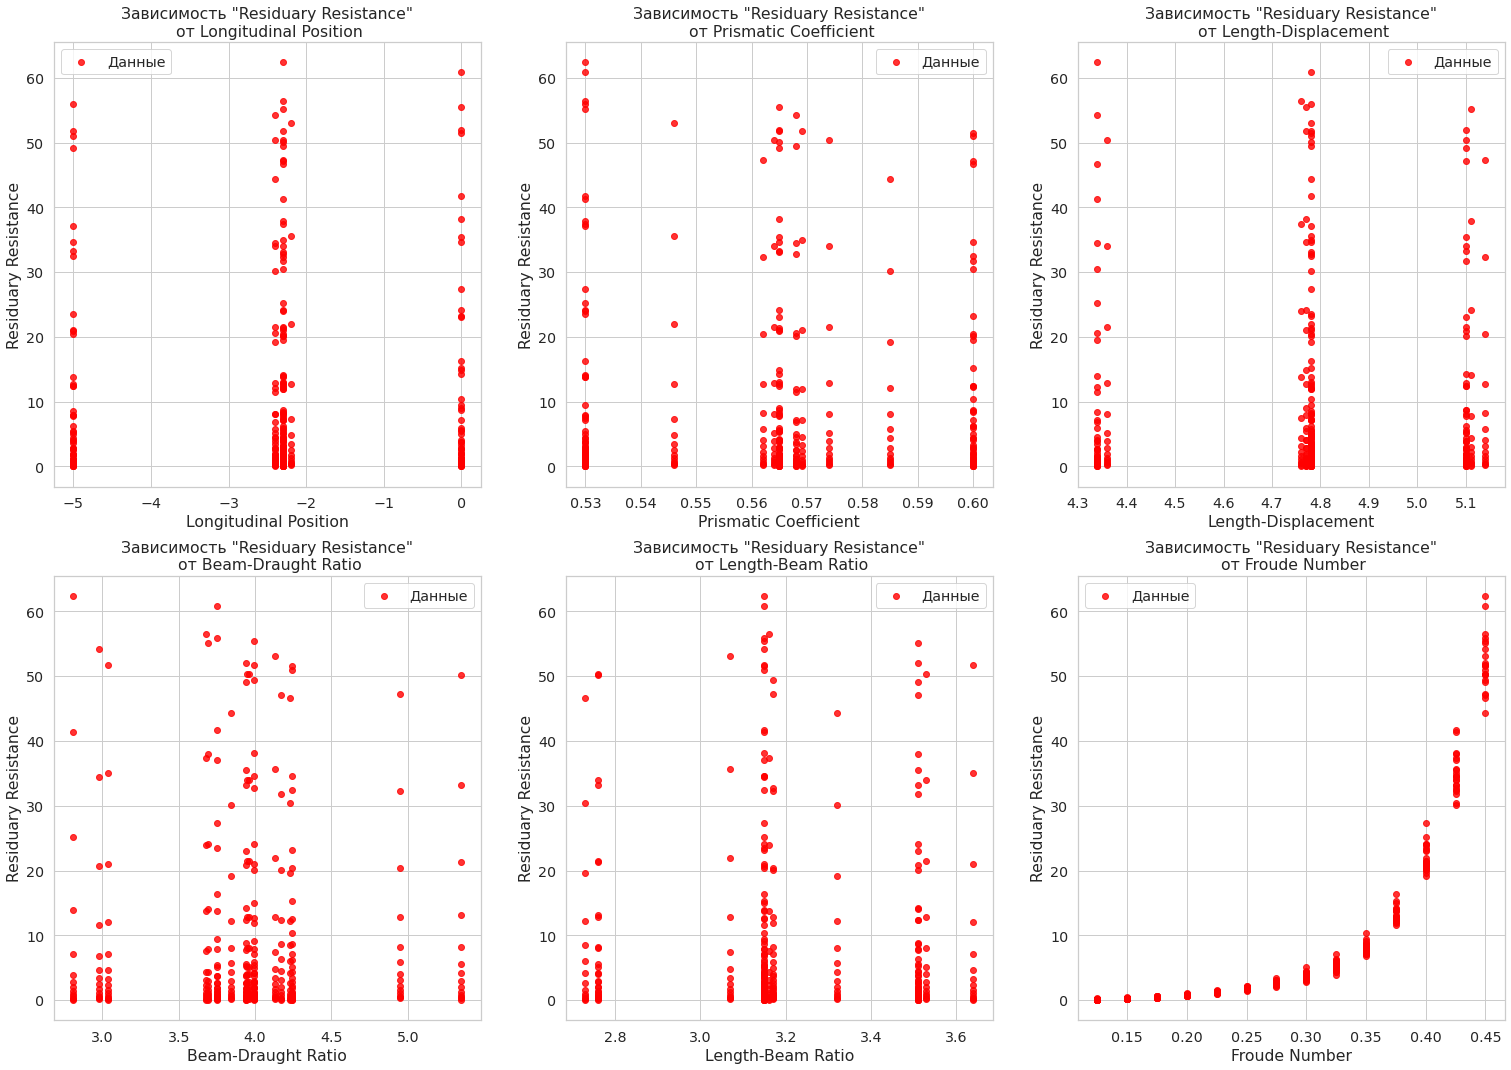

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(26, 18))
axs = axs.flatten()

target = columns[-1]

for feature, ax in zip(columns[:-1], axs):
    ax.scatter(yacht[feature], yacht[target], label='Данные', color='r', alpha=0.8)
    ax.set_title("Зависимость \"" + target + "\"\n от " + feature)
    ax.legend(loc='best')
    ax.set_xlabel(feature)
    ax.set_ylabel(target)

fig.show()

Взглянем еще на поведение целевого признака от $Froude Number^2$ и $e^{Froude Number}$, так как остальные признаки не кажутся полезными

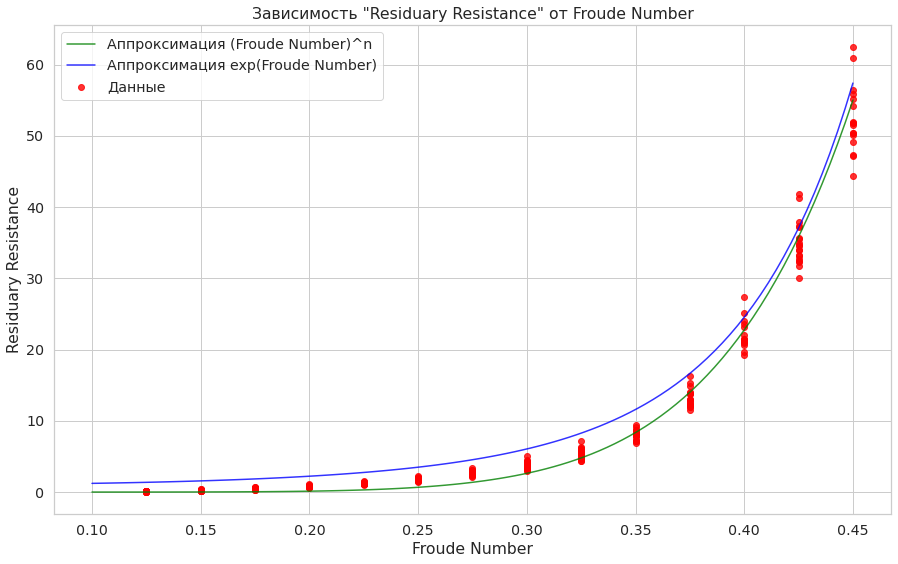

In [ ]:
plt.figure(figsize=(15, 9))

xs = np.linspace(0.1, 0.45, 100)
n = 3

plt.scatter(X_train["Froude Number"], y_train, label='Данные', color='r', alpha=0.8)
for n in [7.5]:
    plt.plot(xs, 55/(0.45 ** n)*xs**n, label='Аппроксимация (Froude Number)^n', color='g', alpha=0.8)
plt.plot(xs, np.exp(20*xs**2), label='Аппроксимация exp(Froude Number)', color='b', alpha=0.8)
plt.title("Зависимость \"" + target + "\" от Froude Number")
plt.legend(loc='best')
plt.xlabel("Froude Number")
plt.ylabel(target)

fig.show()

In [ ]:
feature = 'Froude Number'
fixed_X = X.copy()
fixed_X[feature+' exp'] = np.exp(20*fixed_X[feature]**2)
n = 7.5
fixed_X[feature+'^n'] = 55/(0.45 ** n)*fixed_X[feature]**n

fixed_X_train, fixed_X_test = train_test_split(fixed_X, test_size=0.20, random_state=random_state)

features = [feature, feature+' exp', feature+'^n']

data = np.empty(shape=(3, 3), dtype=object)

for i, feature in enumerate(features):
    print("========================================================================================================================================")
    print("                         -------- Проверка", feature, "в качестве главного признака ---------")
    for j, tp in enumerate(scorings):
        model = BestFeaturesSelection(estimator=LinearRegression, scoring=scorings[tp], val_size=0.25, random_state=random_state)
        model.fit(fixed_X_train[feature][:, np.newaxis], y_train)
        prediction = model.predict(fixed_X_test[feature])
        score = scorings[tp](prediction, y_test)
        print("========================================================================================================================================")
        print("                     Результат: ")
        print("Метод:", tp)
        print(f"Ошибка: {score}")
        # print(model._best_subset)
        print(f"Лучшие параметры:")
        print("Bitmask:", "".join(np.array(model._best_subset).astype(np.int64).astype(np.str)))
        print(" -", " \n - ".join(np.array([feature])[model._best_subset]))
        print("========================================================================================================================================")
        print()

        data[i, j] = f"Ошибка: {score:0.3f}"
        
    print()

check = pd.DataFrame(data=data, columns=features, index=scorings.keys())

                         -------- Проверка Froude Number в качестве главного признака ---------
                     Результат: 
Метод: MSE
Ошибка: 77.43146349907319
Лучшие параметры:
Bitmask: 1
 - Froude Number

                     Результат: 
Метод: MAE
Ошибка: 6.972380774896141
Лучшие параметры:
Bitmask: 1
 - Froude Number

                     Результат: 
Метод: MAPE
Ошибка: 2.5865339778721497
Лучшие параметры:
Bitmask: 1
 - Froude Number


                         -------- Проверка Froude Number exp в качестве главного признака ---------
                     Результат: 
Метод: MSE
Ошибка: 2.3535727667140836
Лучшие параметры:
Bitmask: 1
 - Froude Number exp

                     Результат: 
Метод: MAE
Ошибка: 1.0083856926995312
Лучшие параметры:
Bitmask: 1
 - Froude Number exp

                     Результат: 
Метод: MAPE
Ошибка: 0.5007881946842114
Лучшие параметры:
Bitmask: 1
 - Froude Number exp


                         -------- Проверка Froude Number^n в качестве главного при

-------------------------------------------------------------------------------------
Summary

In [ ]:
check

,Froude Number,Froude Number exp,Froude Number^n
MSE,Ошибка: 77.431,Ошибка: 6.972,Ошибка: 2.587
MAE,Ошибка: 2.354,Ошибка: 1.008,Ошибка: 0.501
MAPE,Ошибка: 2.056,Ошибка: 0.927,Ошибка: 0.217


**В результате:**

На деле, одного признака оказалось достаточно, чтобы научиться очень точно определять значение. Результаты с последними 4-мя признаками на тестовой выборке оказались хуже, чем только с одним, не аппроксимированным под экспоненту/степенную функцию

А преобразованный признак Froude Number дал очень высокую точность без использования других признаков, которые по графикам не давали никаких интересных зависимостей

##### **Boston Housing Prices**

Цены на дома в Бостоне в зависимости от ряда особенностей

 \+ графики зависимости целевой переменной от каждого признака

In [ ]:
columns = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat', 'medv']

housing = pd.read_csv('BostonHousing.txt')

housing.sample(7)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
338,0.03306,0.0,5.19,0,0.515,6.059,37.3,4.8122,5,224,20.2,396.14,8.51,20.6
404,41.52920,0.0,18.10,0,0.693,5.531,85.4,1.6074,24,666,20.2,329.46,27.38,8.5
117,0.15098,0.0,10.01,0,0.547,6.021,82.6,2.7474,6,432,17.8,394.51,10.30,19.2
428,7.36711,0.0,18.10,0,0.679,6.193,78.1,1.9356,24,666,20.2,96.73,21.52,11.0
356,8.98296,0.0,18.10,1,0.770,6.212,97.4,2.1222,24,666,20.2,377.73,17.60,17.8
186,0.05602,0.0,2.46,0,0.488,7.831,53.6,3.1992,3,193,17.8,392.63,4.45,50.0
423,7.05042,0.0,18.10,0,0.614,6.103,85.1,2.0218,24,666,20.2,2.52,23.29,13.4


In [ ]:
target = columns[-1]
features = columns[:-1]
X = housing.loc[:, features]
y = housing.loc[:, target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state)

scorings = {"MSE": mean_squared_error, "MAE": mean_absolute_error, "MAPE": mean_absolute_percentage_error}

colors = []

for tp in scorings:
    model = BestFeaturesSelection(estimator=LinearRegression, scoring=scorings[tp], val_size=0.25, random_state=random_state)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    score = scorings[tp](prediction, y_test)
    colors = ['b' if v else 'r' if i==3 else 'g' for i, v in enumerate(model._best_subset)]
    print("========================================================================================================================================")
    print("                     Результат: ")
    print("Метод:", tp)
    print(f"Ошибка: {score}")
    # print(model._best_subset)
    print(f"Лучшие параметры:")
    print("Bitmask:", "".join(np.array(model._best_subset).astype(np.int64).astype(np.str)))
    print(" -", " \n - ".join(np.array(columns[:-1])[model._best_subset]))
    print("========================================================================================================================================")
    print()

                     Результат: 
Метод: MSE
Ошибка: 23.037631710413827
Лучшие параметры:
Bitmask: 1100010111101
 - crim 
 - zn 
 - rm 
 - dis 
 - rad 
 - tax 
 - ptratio 
 - lstat

                     Результат: 
Метод: MAE
Ошибка: 3.300281646590398
Лучшие параметры:
Bitmask: 1101010111101
 - crim 
 - zn 
 - chas 
 - rm 
 - dis 
 - rad 
 - tax 
 - ptratio 
 - lstat

                     Результат: 
Метод: MAPE
Ошибка: 0.24154744427943142
Лучшие параметры:
Bitmask: 1100010111101
 - crim 
 - zn 
 - rm 
 - dis 
 - rad 
 - tax 
 - ptratio 
 - lstat



Методы оказались почти полностью "солидарны" по поводу 8 признаков выше, и один сверх того (chas)добавился на случае MAE

In [ ]:
colors = ['b' if v else 'r' if i==3 else 'grey' for i, v in enumerate(model._best_subset)]
colors

['b', 'b', 'grey', 'r', 'grey', 'b', 'grey', 'b', 'b', 'b', 'b', 'grey', 'b']

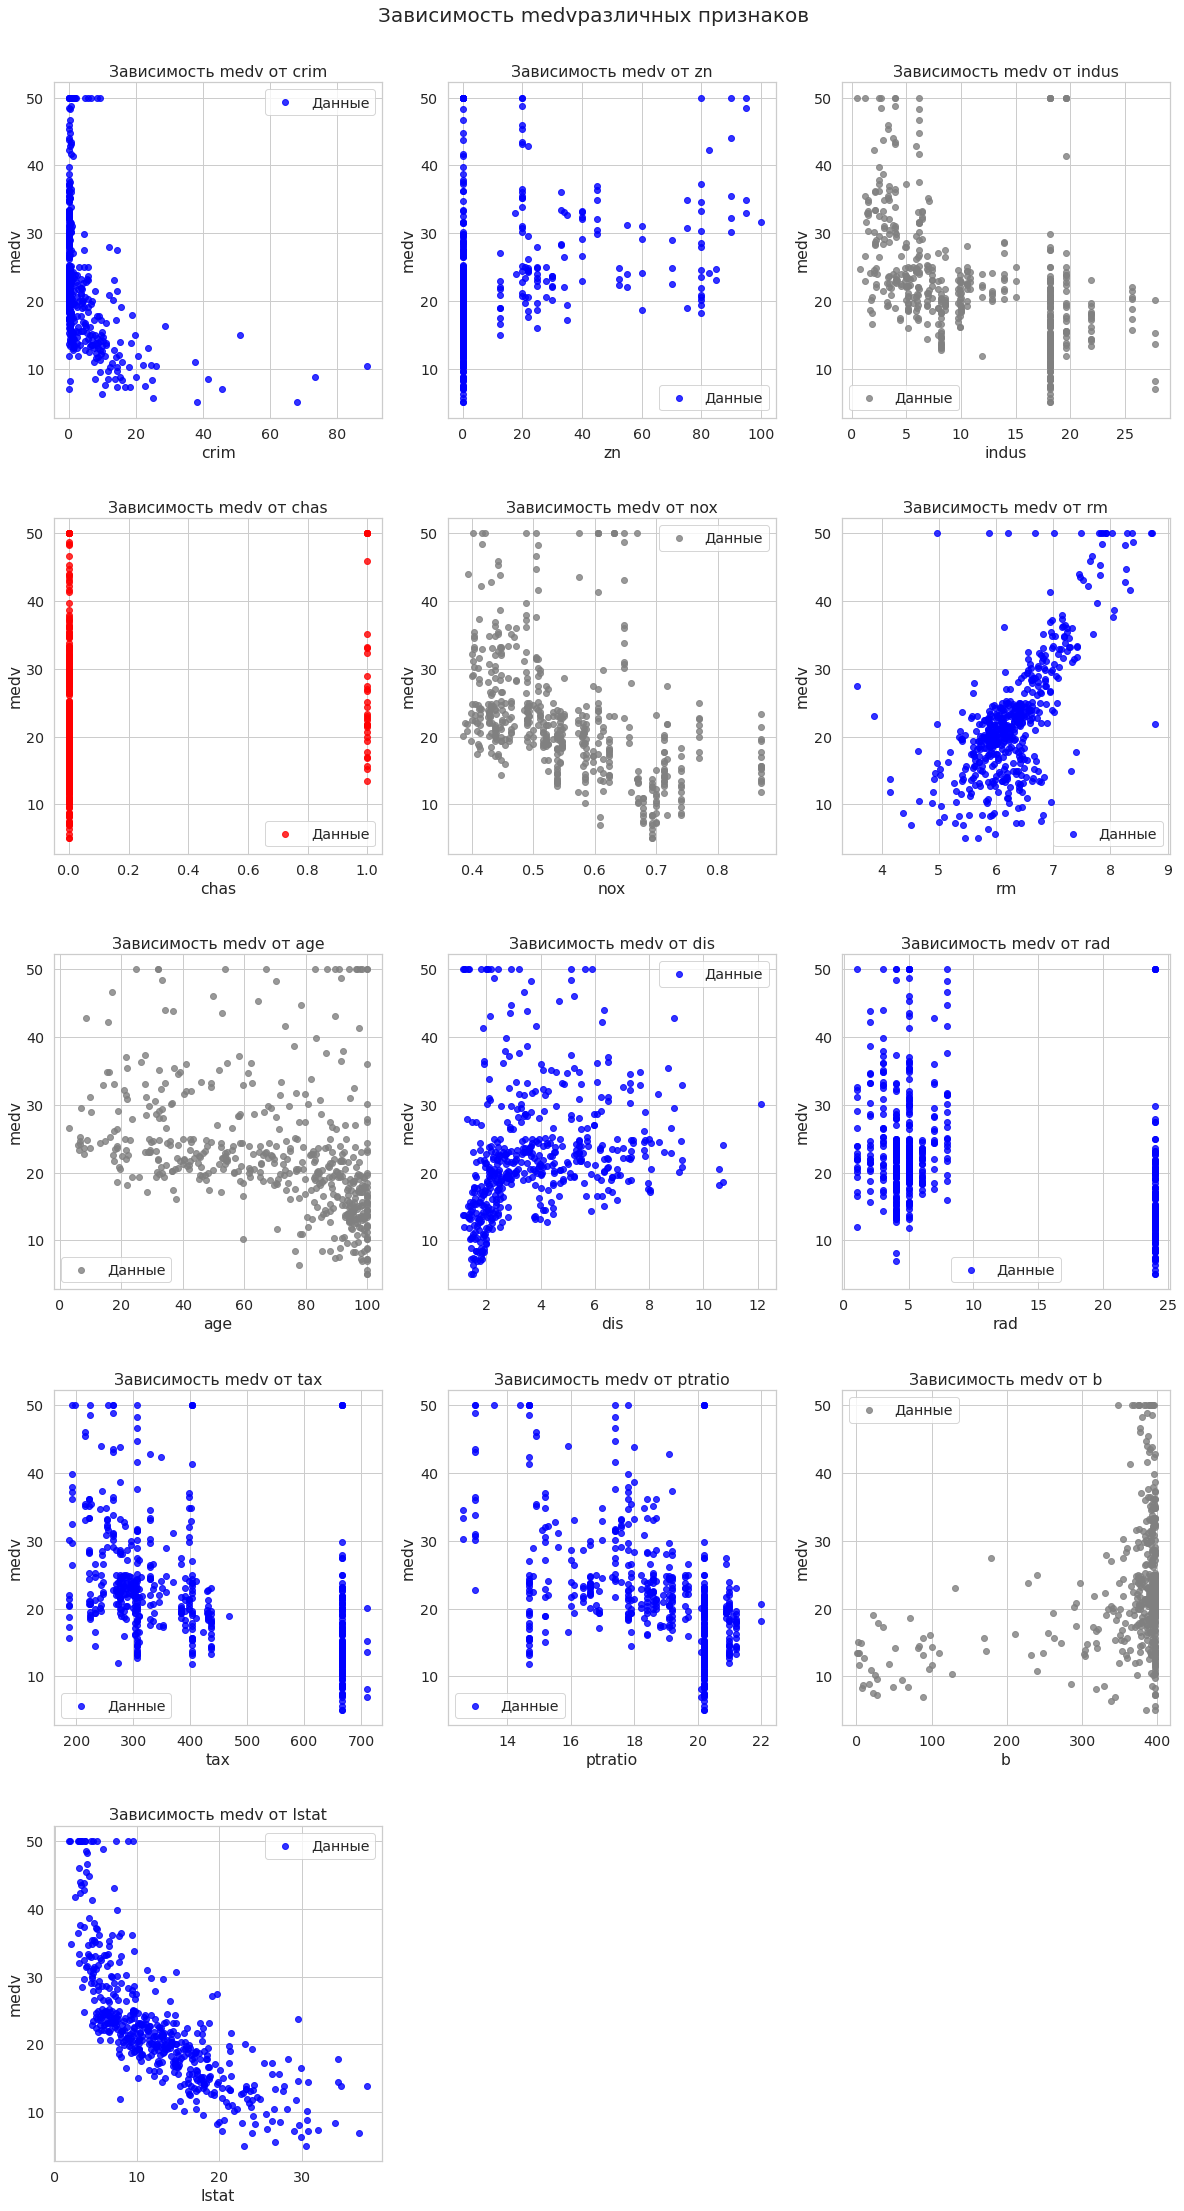

In [ ]:
fig = plt.figure(figsize=(20, 35))
axs = axs.flatten()

for i, (feature, color) in enumerate(zip(columns[:-1], colors)):
    ax = plt.subplot(5, 3, i+1)
    ax.scatter(housing[feature], housing[target], label='Данные', color=color, alpha=0.8)
    ax.set_title("Зависимость " + target + " от " + feature)
    ax.legend(loc='best')
    ax.set_xlabel(feature)
    ax.set_ylabel(target)

fig.subplots_adjust(top=0.95, hspace=0.3)
fig.suptitle("Зависимость " + target + "различных признаков", fontsize=20)
manager = plt.get_current_fig_manager()
manager.full_screen_toggle()
fig.show()

*Синими* помечены те данные, по которым все три метода оказались солидарны. *Красный* - CHAS - параметр, который посчитал полезным MAE. Бесполезные данные - *серые*

Посмотрим на графики:

1. Есть некоторая заметная убывающая зависимость стоимости жилья от числа преступления в районе (CRIM) - очевидно и возрастающая от ZN (доля жилой земли, выделенной под участки площадью более 25000 кв.фт.) - большие, дорогие участки рядом увеличивают и стоимость остальных домов в округе

2. Наиболее заметная зависимость - убывающая от LSTAT - процента населения с низким социальным статусом - что вполне логично: чем больше стоимость жилья, тем лучше население, в нем живущее и наоборот; и возрастающая от RM - среднее число комнат в жилище

3. Так же оказались полезными признаки:

* CHAS (наличие реки Чарльз рядом) - не понятно, как он здесь затесался
* DIS - взвешенное расстояние до центров трудоустройства (важный параметр для приезжих)
* RAD - индекс доступности до шоссе (возможнсть добраться до работы быстрее)
* TAX - ставка налогообложения жилища на каждые 10к долларов стоимости (все и так понятно)
* PTRATIO - соотношение ученики/учителя (может указывать на "спальность" района)

4. Из неуказанных признаков кажутся полезными так же признаки NOX - Концентрация оксидов азота, B - коэффициент связанный с числом черного населения и AGE - возраст жилья

Уберем CHAS, добавим указанные выше признаки и посмотрим еще раз

In [ ]:
target = columns[-1]
features = np.array(columns[:-1])[model._best_subset]
features = np.append(features, ['nox', 'tax', 'age'])
features
X = housing.loc[:, features]
y = housing.loc[:, target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state)

scorings = {"MSE": mean_squared_error, "MAE": mean_absolute_error, "MAPE": mean_absolute_percentage_error}

model = LinearRegression()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

for tp in scorings:
    score = scorings[tp](prediction, y_test)
    print("=========================")
    print("Результат: ")
    print("Метод:", tp)
    print(f"Ошибка: {score}")
    print("=========================")
    print()

Результат: 
Метод: MSE
Ошибка: 21.058277171246427

Результат: 
Метод: MAE
Ошибка: 3.212230230666355

Результат: 
Метод: MAPE
Ошибка: 0.2916988739692414



MSE=23, MAE=3.3, MAPE=0.24 на FeaturesSelection VS MSE=21, MAE=3.2, MAPE=0.29 на FeaturesSelection + ручной выбор

Дополнительный ручной выбор признаков снизил ошибку в некоторых случаях

**Вывод:**

Подобный метод подбора критериев может быть как полезен, так и бесполезен, что показали 2 примера выше. Его лучше совмещать с 

* ручным выбором признакам на основе каких-то общепринятых закономерностей и интуиции на основе "пристального взгляда" в данные, если такая возможность есть; 
* с методом отбора признаков на основе критерия незначимости критерия (равенства коэффициента 0)
* пересаливанием train и valid выборок, так как может повезти/не повезти и какой-то признак окажется полезным, в то время как это не так

Очевидно, что человек не всегда может заметить какие-то признаки, которые поодиночке не дают никакого вклада, но вместе оказываются полезными. Но на откуп алгоритму не стоит отдавать отбор признаков, т.к. первый пример показал, что для он может выбрать несколько бесполезных по своей сути признаков

___
## Задача 3.
Напомним, что в гауссовской линейной модели случайный шум $\varepsilon$ имеет многомерное нормальное распределение с нулевым векторомdef средних и матрицей ковариаций $\sigma^2I_n$, то есть $\varepsilon \sim \mathcal{N}\left(0, \sigma^2I_n\right)$. В таком случае у каждого $\varepsilon_i$ одинаковая дисперсия, данное свойство однородности дисперсии называется *гомоскедастичностью*. На практике не редко дисперсия $\varepsilon_i$ может как-то зависеть от $x$ или, например, от номера наблюдения. В таком случае дисперсия $\varepsilon_i$ непостоянна и тогда говорят о *гетероскедастичности*.

Вам предлагается провести эксперимент по определению реального уровня значимости критерия для проверки гипотезы о незначимости коэффициента в гауссовской линейной модели, если на самом деле в данных присутствует гетероскедастичность. 

Для этого смоделируйте некоторым образом двумерные данные $x$ и посчитайте по ним ожидаемый отклик 
	$y(x) = \theta_0 + \theta_1 x^{(1)} + \theta_2 x^{(2)}$, где коэффициенты выберите по своему усмотрению, рассмотрев два случая:
* $\theta_0 \not= 0, \theta_1 \not= 0, \theta_2 = 0$
* $\theta_0 \not= 0, \theta_1 \not= 0, \theta_2 \not= 0$


Зашумите набор значений $y(x_i)$ некоторым нормальным шумом с нулевым средним и меняющейся дисперсией, рассмотрев два случая:
* стандартное отклонение меняется как $\sigma(x) = \sigma_0 + \sigma_1 x^{(1)} + \sigma_2 x^{(2)}$, где все коэффициенты положительны;
* стандартное отклонение меняется как $\sigma(i) = \sigma_0 + \sigma_1 i$, где все коэффициенты положительны, а $i$ &mdash; номер наблюдения в обучающей выборке.

По таким данным обучите	линейную модель и проверьте гипотезу $\mathsf{H}_0\colon \theta_2 = 0$. 

Для каждого случая повторите эксперимент достаточное количество раз и посчитайте долю случаев, в которых гипотеза отвергается. 

**Решение:**

In [101]:
def generate_data(nsamples=1000, nfeatures=2):
    return np.abs(sps.cauchy.rvs(size=(nsamples, nfeatures)))

def generate_thetas(nfeatures=3):
    return sps.uniform(loc = 1, scale=1000).rvs(nfeatures)

def make_some_noize(X, Y, tp=-1, sigma0=None, sigma1=None, sigma2=None, normalize=False):
    X_intercept = np.hstack([X, np.ones(shape=(X.shape[0], 1))])
    if tp == 'std':
        sigmas = sigma0
    elif tp == 0:
        if normalize:
            return X_intercept, Y
        return X, Y
    elif tp == 1:
        sigmas = X_intercept @ np.array([sigma2, sigma1, sigma0])
    elif tp == 2:
        sigmas = sigma0 + np.arange(Y.size) * sigma1
    else:
        raise ValueError("Неизвестный тип шума")
    Y = Y + sps.norm(scale=sigmas).rvs(Y.size)
    if normalize:
        X = (X_intercept.T / sigmas).T
        Y = Y / sigmas
    return X, Y

def generate_X_Y(nsamples=1000, nfeatures=2, noize_tp=1, is_last_zero=True, normalize_noize=False, sigmas=dict()):
    X = generate_data(nsamples, nfeatures)
    X_intercept = np.hstack([X, np.ones(shape=(nsamples, 1))])
    thetas = generate_thetas(nfeatures + 1)
    thetas = thetas[::-1]
    if is_last_zero:
        thetas[0] = 0
    Y = X_intercept @ thetas
    X, Y = make_some_noize(X, Y, tp=noize_tp, **sigmas, normalize=normalize_noize)
    
    return X, Y, thetas

In [ ]:
alpha = 0.05

In [114]:
def check_criterion(nsamples=1000, nfeatures=2, noize_tp=1, is_last_zero=True, normalize_noize=False, sigmas=dict()):
    X, Y, thetas = generate_X_Y(nsamples, nfeatures, noize_tp, is_last_zero, normalize_noize, sigmas)
    model = MyLinearRegression().fit(X, Y, names=['θ_2', 'θ_1', 'intercept=θ_0'], fit_intercept=(not normalize_noize))
    # return X, Y, thetas
    return model.summary(suppress_output=True)
    # return model.summary(suppress_output=False)

def check_case(checks, sigmas, show_progress=True, nsamples=1000, normalize_noize=False):
    data = np.empty(shape=(4, 2))
    for i, tp in enumerate(['std', 0, 1, 2]):
        for j, is_last_zero in enumerate([True, False]):
            if show_progress:
                data[i, j] = np.array([check_criterion(nsamples=nsamples, is_last_zero=is_last_zero, noize_tp=tp, normalize_noize=normalize_noize, sigmas=sigmas).loc['θ_2', 'p-value'] >= alpha for _ in tqdm(range(checks))]).mean()
            else:
                data[i, j] = np.array([check_criterion(nsamples=nsamples, is_last_zero=is_last_zero, noize_tp=tp, normalize_noize=normalize_noize, sigmas=sigmas).loc['θ_2', 'p-value'] >= alpha for _ in range(checks)]).mean()

    return pd.DataFrame(data=data, columns=['θ_2 = 0', 'θ_2 != 0'], index=['σ(x)_std', 'σ(x)_0', 'σ(x)_1', 'σ(x)_2'])

In [104]:
check_case(checks=200, sigmas={'sigma0': 0.001, 'sigma1': 0.001, 'sigma2': 0.001}, show_progress=True).style.format('{:.3f}')

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

,θ_2 = 0,θ_2 != 0
σ(x)_std,0.935,0.000
σ(x)_0,0.870,0.000
σ(x)_1,0.140,0.000
σ(x)_2,0.940,0.000


In [105]:
check_case(checks=200, sigmas={'sigma0': 0.01, 'sigma1': 0.01, 'sigma2': 0.01}, show_progress=True).style.format('{:.3f}')

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

,θ_2 = 0,θ_2 != 0
σ(x)_std,0.975,0.000
σ(x)_0,0.820,0.000
σ(x)_1,0.110,0.000
σ(x)_2,0.945,0.000


In [112]:
check_case(checks=200, sigmas={'sigma0': 2, 'sigma1': 5, 'sigma2': 3}, show_progress=True).style.format('{:.3f}')

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

,θ_2 = 0,θ_2 != 0
σ(x)_std,0.925,0.000
σ(x)_0,0.880,0.000
σ(x)_1,0.155,0.000
σ(x)_2,0.970,0.000


Объясним, что значат значения в табличке

В ячейке соответственно доля отвержения критерия. 

Строки:

* σ(x)_std - это специальный случай, когда $\varepsilon \sim \mathcal{N}\left(0, \sigma^2I_n\right)$, т.е. когда везде дисперсия одинаковая

* σ(x)_0 - отсутствие шума вообще, т.е. коэффициенты восстанавливаются однозначно

Случаи выше - это такие маркеры, которые вообще показывают, как у нас вообще работает критерий в случае, соответствующему теории

* σ(x)_1 - случай с $\sigma(x) = \sigma_0 + \sigma_1 x^{(1)} + \sigma_2 x^{(2)}$

* σ(x)_2 - случай с $\sigma(i) = \sigma_0 + \sigma_1 i$

Столбцы однозначно объясняются: это значения в случае $ \theta_2 = 0$ и $ \theta_2 \neq 0$


Что мы в итоге имеем: критерий работает хуже в случае - значительно хуже в случае σ(x)_2 - когда данные имеют неодинаковые дисперсии. Попробуем это решить нормировкой (т.е. прикинемся Вангой и воспользуемся знанием о том, как выглядит дисперсия), т.е. приведем данные к такому состоянию, когда они у всех них будет одинаковая дисперсия, равная 1

Раз мы используем свободный коэффициент, то в коде intercept столбец тоже преображается в ходе таких преобразований)

In [107]:
check_case(checks=200, sigmas={'sigma0': 0.001, 'sigma1': 0.001, 'sigma2': 0.001}, show_progress=True, normalize_noize=True).style.format('{:.3f}')

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

,θ_2 = 0,θ_2 != 0
σ(x)_std,0.945,0.000
σ(x)_0,0.795,0.000
σ(x)_1,0.930,0.000
σ(x)_2,0.970,0.000


In [108]:
check_case(checks=200, sigmas={'sigma0': 0.01, 'sigma1': 0.01, 'sigma2': 0.01}, show_progress=True, normalize_noize=True).style.format('{:.3f}')

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

,θ_2 = 0,θ_2 != 0
σ(x)_std,0.930,0.000
σ(x)_0,0.840,0.000
σ(x)_1,0.950,0.000
σ(x)_2,0.940,0.000


In [109]:
check_case(checks=200, sigmas={'sigma0': 2, 'sigma1': 5, 'sigma2': 3}, show_progress=True, normalize_noize=True).style.format('{:.3f}')

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

,θ_2 = 0,θ_2 != 0
σ(x)_std,0.955,0.000
σ(x)_0,0.825,0.000
σ(x)_1,0.945,0.000
σ(x)_2,0.955,0.000


Как видим, отвержение начало работать сильно лучше - сработал трюк с семинара с приведением всех данных к виду с одинаковой дисперсией, чтобы модель соответствовала требуемой

**Вывод:**

Имеющийся у нас метод отвержения гипотезы о незначимости параметра опирается на гомоскедастичную модель, поэтому в случае, отличающемся от такового, критерий работает сильно хуже, т.е. его мощность становится ниже

Отметим среди прочего, что в случае когда дисперсия имела вид $\sigma(i) = \sigma_0 + \sigma_1 i$ критерий работал неплохо и так. Скорее всего это связано с тем фактом, что дисперсия у всех элементов была в районе $\le 1$ в первых двух случаях, так что шум не слишком сильно влиял на работу и критерия, и регрессии в целом

> (? хотя это не объясняет, почему при большей дисперсии критерий продолжал работать хорошо ?)

Т.е. в целом, когда шума небольшой, то даже если он сильно разнится между элементами выборки, то критерий срабатыал

Поэтому в таком случае, когда мы все-таки Ванга и предполагаем, как ведет себя дисперсия, эти знания стоит применит - потому что увидели на практике, что это помогает решить проблему с плохо работающим критерием
